In [1]:
from IPython.display import clear_output
from typing import List, Optional

import datetime
import functools
import gpflow as gpf
import hydra
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import palettable
import tensorflow as tf
import tensor_annotations.tensorflow as ttf
import tensorflow_probability as tfp

from gpflow import default_float, default_jitter
from gpflow.conditionals import uncertain_conditional, base_conditional
from matplotlib import cm
from numpy import random
from omegaconf import DictConfig
from simenvs import make

from modeopt.cost_functions import ControlQuadraticCostFunction, TargetStateCostFunction, StateDiffCostFunction, quadratic_cost_fn
from modeopt.controllers.utils import initialise_deterministic_trajectory, build_mode_variational_objective
from modeopt.controllers import TrajectoryOptimisationController
from modeopt.constraints import build_mode_chance_constraints_scipy
from modeopt.custom_types import Dataset
from modeopt.dynamics.conditionals import svgp_covariance_conditional
from modeopt.plotting import ModeOptContourPlotter
from modeopt.rollouts import rollout_controls_in_dynamics, rollout_controller_in_dynamics, rollout_controller_in_env, collect_data_from_env
from modeopt.trajectories import ControlTrajectoryDist
from modeopt.utils import model_from_DictConfig, combine_state_controls_to_input, append_zero_control
from modeopt.mode_opt import ModeOpt
from mogpe.keras.callbacks.tensorboard import PlotFn, TensorboardImageCallback
from mogpe.keras.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.keras.plotting import MixtureOfSVGPExpertsContourPlotter
from mogpe.keras.utils import sample_mosvgpe_inducing_inputs_from_data, model_from_yaml

%matplotlib inline

tfd = tfp.distributions

CMAP = palettable.scientific.sequential.Bilbao_15.mpl_colormap

meaning_of_life = 42
tf.random.set_seed(meaning_of_life)
np.random.seed(meaning_of_life)

## Initialise environment

In [2]:
env_name = "velocity-controlled-point-mass/scenario-7"

In [3]:
env = make(env_name)
state_dim = env.observation_spec().shape[0]
control_dim = env.action_spec().shape[0]

No constant_error found in toml config so using default : 0.0


## ModeOpt config

In [4]:
start_state = np.array([[-1.0, -2.0]])
target_state = np.array([[1.7, 3.0]])
mode_satisfaction_prob = 0.8

## Sample initial data set from desired mode

(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)
(1, 2)
(2,)
(15, 2)
(2,)


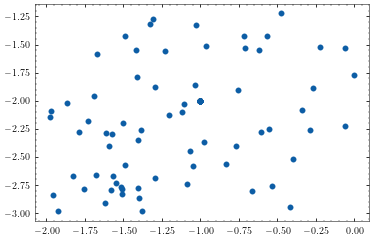

In [5]:
def sample_env_trajectories(horizon=15, num_trajectories=10):
    X, Y = [], []
    for i in range(num_trajectories):
        controls = np.random.uniform(
            env.action_spec().minimum,
            env.action_spec().maximum,
            (horizon, env.action_spec().shape[-1]),
        )
        X_, Y_ = collect_data_from_env(env, start_state=start_state, controls=controls)
        X.append(X_)
        Y.append(Y_)
    X = np.concatenate(X, 0)
    Y = np.concatenate(Y, 0)
    width = 1.0
    mask_1 = X[:, 0] > start_state[0, 0] - width
    mask_2 = X[:, 0] < start_state[0, 0] + width
    mask_3 = X[:, 1] > start_state[0, 1] - width
    mask_4 = X[:, 1] < start_state[0, 1] + width
    mask = mask_1 & mask_2 & mask_3 & mask_4
    X_trimmed = X[mask]
    Y_trimmed = Y[mask]
    print(X_trimmed.shape)
    print(Y_trimmed.shape)
    return (X_trimmed, Y_trimmed)

initial_dataset = sample_env_trajectories(horizon = 15, num_trajectories=50)
dataset = initial_dataset
plt.scatter(dataset[0][:, 0], dataset[0][:, 1])
plt.show()

## Train dynamics on initial data set or load from config

In [6]:
initial_num_epochs = 20000
# num_epochs = 300
num_epochs = 1500
# batch_size = 128
batch_size = initial_dataset[0].shape[0]
dynamics_logging_epoch_freq = 100

load_from_config = True
# load_from_config = False
yaml_cfg_filename = "./keras_configs/mode_opt_explore_scenario_7.yaml"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-29-18-14/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-13-33/ckpts"
load_ckpt_dir = "./experiments/exploration-prob-0.8/2022-03-30-14-22/ckpts"

In [7]:
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M') #  now
log_dir = os.path.join(f"./experiments/mvn-diag/explorative-prob-{mode_satisfaction_prob}", now_time)

In [8]:
if load_from_config:
    mode_optimiser = ModeOpt.load(load_ckpt_dir)
    mode_optimiser.log_dir = log_dir
else:
    mode_optimiser = model_from_yaml(yaml_cfg_filename, custom_objects={"ModeOpt": ModeOpt})
    mode_optimiser.dataset = (tf.constant(initial_dataset[0], dtype=default_float()),
                              tf.constant(initial_dataset[1], dtype=default_float())
                             )
    sample_mosvgpe_inducing_inputs_from_data(initial_dataset[0], mode_optimiser.dynamics.mosvgpe)
    mode_optimiser.dynamics_fit_kwargs.update({"epochs": initial_num_epochs, "batch_size": batch_size, "validation_split": 0.2})
#     dynamics_plotting_callbacks = build_contour_plotter_callbacks(mode_optimiser.dynamics.mosvgpe, logging_epoch_freq=dynamics_logging_epoch_freq, log_dir=mode_optimiser.log_dir)
#     mode_optimiser.add_dynamics_callbacks(dynamics_plotting_callbacks)
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.inducing_variable, False)
    mode_optimiser.optimise_dynamics()
#     gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)

2022-04-11 15:49:09.301670: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


setting desired mode to 1
╒════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════╕
│ name                                                           │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value                                    │
╞════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════╡
│ IndependentPosteriorMultiOutput.kernel.kernels[0].variance     │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.4978003107997662                       │
├────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ IndependentPosteriorMultiOutput.kerne

2022-04-11 15:49:10.155687: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-11 15:49:10.155711: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-11 15:49:10.155884: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Update the data set.

In [9]:
mode_optimiser.start_state = tf.constant(start_state, dtype=default_float())

Set the correct desired dynamics mode.

In [10]:
def which_desired_mode(mode_optimiser, initial_dataset):
    probs = mode_optimiser.dynamics.mosvgpe.gating_network.predict_mixing_probs(initial_dataset[0])
    mean_probs = tf.reduce_mean(probs, 0)
    return int(tf.math.argmax(mean_probs))

desired_mode = which_desired_mode(mode_optimiser, initial_dataset)
print("Desired mode is {}".format(desired_mode))
mode_optimiser.desired_mode = desired_mode

Desired mode is 1


Save the learned dynamics model.

In [11]:
mode_optimiser.save()

## Configure the explorative controller

In [12]:
horizon = 15
max_iterations = 1000
keep_last_solution = True
method = "SLSQP"

In [13]:
terminal_state_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 100
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 0.01
state_diff_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 2.0
# control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 0.1
control_cost_matrix = tf.eye(control_dim, dtype=default_float()) * 1.0

# terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=start_state)
terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, target_state=target_state)
control_cost_fn = ControlQuadraticCostFunction(weight_matrix=control_cost_matrix)
state_diff_cost_fn = StateDiffCostFunction(weight_matrix=state_diff_cost_matrix, target_state=target_state)

cost_fn = control_cost_fn + state_diff_cost_fn
# cost_fn = state_diff_cost_fn
# cost_fn = control_cost_fn
# cost_fn = control_cost_fn + state_diff_cost_fn + terminal_cost_fn
# cost_fn = state_diff_cost_fn
# cost_fn = terminal_cost_fn + state_diff_cost_fn

In [14]:
def explorative_objective(initial_solution: ControlTrajectoryDist) -> ttf.Tensor0:
    control_means = initial_solution(variance=False)
    control_vars = None
    state_means, state_vars = rollout_controls_in_dynamics(
        dynamics=mode_optimiser.dynamics,
        start_state=start_state,
        control_means=control_means,
        control_vars=control_vars,
    )
    
    input_means, input_vars = combine_state_controls_to_input(
        state_means[1:, :], control_means, state_vars[1:, :], control_vars
    )
    h_means, h_vars = mode_optimiser.dynamics.mosvgpe.gating_network.gp.predict_f(input_means, full_cov=True)
    h_vars = h_vars + tf.eye(h_vars.shape[1], h_vars.shape[2], dtype=default_float()) * 1e-6
#     h_dist = tfd.MultivariateNormalFullCovariance(h_means, h_vars[0, :, :]**2)
    h_dist = tfd.MultivariateNormalDiag(h_means, tf.linalg.diag_part(h_vars[0, :, :])**2)
#     h_dist = tfd.MultivariateNormalFullCovariance(h_means[:, mode_optimiser.desired_mode], h_vars[0, :, :])
#     gating_entropy_diag = h_dist_diag.entropy()
#     tf.print('mvn')
#     tf.print(tf.reduce_sum(gating_entropy))
    gating_entropy = h_dist.entropy()
    tf.print(tf.reduce_sum(gating_entropy))
    tf.print(cost_fn(state_means, control_means, state_vars, control_vars))
    return -tf.reduce_sum(gating_entropy) + cost_fn(state_means, control_means, state_vars, control_vars)

In [15]:
def find_initial_solution_in_desired_mode():
    fake_target_state_in_mode_idx = np.random.choice(np.arange(len(mode_optimiser.dataset[0])), size=1)
    fake_target_state_in_mode = mode_optimiser.dataset[0][fake_target_state_in_mode_idx[0], :state_dim]
    fake_target_state_in_mode = tf.constant([[0, -1]], dtype=default_float())
    
    terminal_state_cost_matrix = tf.eye(state_dim, dtype=default_float()) * 100.0
    control_cost_matrix = tf.eye(control_dim, dtype=default_float())
    
    terminal_cost_fn = TargetStateCostFunction(weight_matrix=terminal_state_cost_matrix, 
                                               target_state=fake_target_state_in_mode)
    control_cost_fn = ControlQuadraticCostFunction(weight_matrix=control_cost_matrix)
    initial_cost_fn = terminal_cost_fn + control_cost_fn

    initial_solution = initialise_deterministic_trajectory(horizon, control_dim)
    objective_fn = build_mode_variational_objective(mode_optimiser.dynamics, initial_cost_fn, start_state)
    explorative_controller = TrajectoryOptimisationController(
        max_iterations=max_iterations,
        initial_solution=initial_solution,
        objective_fn=objective_fn,
        method=method,
    )
    explorative_controller.optimise()
    return explorative_controller.previous_solution

initial_solution_in_mode = find_initial_solution_in_desired_mode()

2022-04-11 15:49:11.331969: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Xnew.shape
(256, 15, 4)
gating_means.shape
(256, 15, 1)
input_mean.shape
(15, 4)
(15, 4)
var_exp: Tensor("Sum_218:0", shape=(15, 1), dtype=float64)
mode_var_exp: Tensor("Sum_219:0", shape=(), dtype=float64)


2022-04-11 15:49:41.425847: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Optimisation result:
     fun: array([66.59696742])
     jac: array([2.69513992e-04, 7.56009729e-04, 5.53638984e-04, 6.17919925e-04,
       8.24734830e-05, 6.56961782e-04, 1.17365008e-04, 7.29399697e-04,
       4.05722417e-04, 7.39736557e-04, 4.61553437e-04, 6.91946622e-04,
       2.84344129e-04, 5.91346487e-04, 9.81022855e-05, 4.57220948e-04,
       7.90776870e-05, 4.21872280e-04, 1.69593489e-04, 5.53104525e-04,
       2.26450631e-04, 7.32156357e-04, 1.44979967e-04, 7.40807270e-04,
       7.21748549e-05, 4.30802069e-04, 1.85513109e-04, 2.63013167e-05,
       3.66076753e-04, 9.75111871e-05])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-0.23821481,  2.13424601, -0.13510465,  1.95088118, -0.07097346,
        1.82675821, -0.02716002,  1.7448613 ,  0.00669778,  1.69276623,
        0.03689614,  1.66185601,  0.0678676 ,  1.64643057,  0.10312259,
        1.6430313 ,  0.14580199,  1.65000104,  0.1990902 ,  

In [16]:
mode_chance_constraints = build_mode_chance_constraints_scipy(mode_optimiser.dynamics, 
                                                              start_state, 
                                                              horizon, 
                                                              control_dim=control_dim,
                                                              lower_bound=mode_satisfaction_prob)
explorative_controller = TrajectoryOptimisationController(
    max_iterations=max_iterations,
    initial_solution=initial_solution_in_mode,
    objective_fn=explorative_objective,
    keep_last_solution=keep_last_solution,
    constraints=[mode_chance_constraints],
    method=method,
)
mode_optimiser.explorative_controller = explorative_controller

## Configure plotter

In [17]:
def create_test_inputs(x_min=[-3, -3], x_max=[3, 3], input_dim=4, num_test: int = 1600, factor: float = 1.2):
    sqrtN = int(np.sqrt(num_test))
    xx = np.linspace(x_min[0] * factor, x_max[0] * factor, sqrtN)
    yy = np.linspace(x_min[1] * factor, x_max[1] * factor, sqrtN)
    xx, yy = np.meshgrid(xx, yy)
    test_inputs = np.column_stack([xx.reshape(-1), yy.reshape(-1)])
    if input_dim > 2:
        zeros = np.zeros((num_test, input_dim - 2))
        test_inputs = np.concatenate([test_inputs, zeros], -1)
    return test_inputs, xx, yy

test_inputs, xx, yy = create_test_inputs()
plotter = ModeOptContourPlotter(mode_optimiser, test_inputs=test_inputs, static=False, explorative=True)

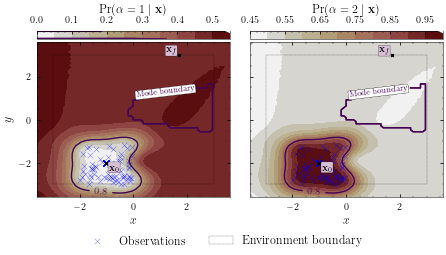

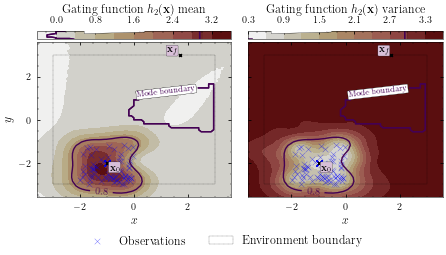

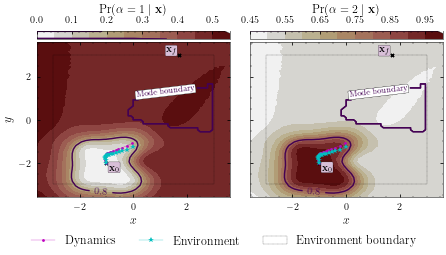

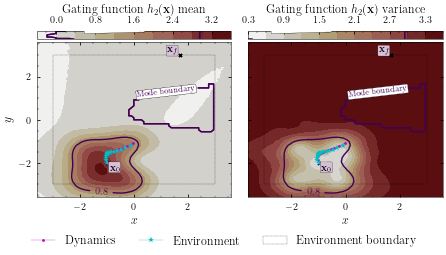

In [18]:
image_save_dir = os.path.join(mode_optimiser.log_dir, "images")
try:
    os.makedirs(image_save_dir)
except FileExistsError:
    pass

def plot_data_over_gating_network_and_save(step: int, epoch: int, save: bool = True):
    plotter.plot_data_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_mixing_probs_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_data_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "data_over_desired_gating_gp_step_{}_epoch_{}.pdf".format(step, epoch))
        plt.savefig(save_filename, transparent=True)

def plot_trajectories_over_gating_network_and_save(step: int, save: bool = True):
    plotter.plot_trajectories_over_mixing_probs()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_mixing_probs_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)
    
    plotter.plot_trajectories_over_desired_gating_network_gp()
    if save:
        save_filename = os.path.join(image_save_dir, "trajectories_over_desired_gating_gp_step_{}.pdf".format(step))
        plt.savefig(save_filename, transparent=True)

plot_data_over_gating_network_and_save(step=0, epoch=0)
plot_trajectories_over_gating_network_and_save(step=0)

## Configure ModeOpt and callbacks

In [19]:
# mode_optimiser.dataset = (mode_optimiser.dataset[0][:130, :], mode_optimiser.dataset[1][:130, :])

In [20]:
# logging_epoch_freq = 60
num_epochs = 10000
logging_epoch_freq = math.floor((num_epochs)/5)
save_epoch_freq = math.floor((num_epochs)/5)
num_steps = 35
dataset = initial_dataset
# batch_size = 128
batch_size = mode_optimiser.dataset[0].shape[0]

mode_optimiser.dynamics_fit_kwargs.update({"epochs": num_epochs, "batch_size": batch_size, "validation_split": 0.2})
mode_optimiser.dynamics_fit_kwargs

{'epochs': 10000, 'batch_size': 125, 'validation_split': 0.2}

Callbacks for dynamics learning.

In [21]:
class PlottingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % logging_epoch_freq == 0:
            plot_data_over_gating_network_and_save(step=step, epoch=epoch)

class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % save_epoch_freq == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(os.path.join(mode_optimiser.ckpt_dir, "step_{}_epoch_{}".format(step, epoch)), save_format="tf")
            
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=500,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
callbacks = [PlottingCallback(),
             CustomSaver(),
             early_stopping_cb,
#              tf.keras.callbacks.ModelCheckpoint(
#                  filepath=os.path.join(save_dir + "ckpts/ModeOptDynamics"),
#                  monitor="loss",
#                  save_format="tf",
#                  save_best_only=False,
#                  save_freq=500),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir)
            ]

2022-04-11 15:50:23.603788: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-11 15:50:23.603805: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-11 15:50:23.604035: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [22]:
mode_optimiser.dynamics(dataset[0]) # call ModeOptDynamics to build it for saving
mode_optimiser.dynamics_callbacks = []
mode_optimiser.add_dynamics_callbacks(callbacks)

In [23]:
# gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.gating_network.gp.kernel, False)
gpf.utilities.set_trainable(mode_optimiser.dynamics.mosvgpe.experts_list[desired_mode].gp.kernel, False)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
319.07761478979859
838.65803665246085
613.416553785728
62342.418833755219
870.70889187665
7671.1724056124049
869.587031236174
2358.6695414879314
769.42958708292565
976.51151723881776
501.50462344073156
841.75472829108674
799.94025687325961
4414.7285298790457
616.44577769403691
782.83848671734336
567.96017113547384
751.4382816862036
836.92920753262456
1549.5923095534135
517.09241411161747
733.932990252915
661.86045638102291
836.06008721115234
571.58489702008933
708.61788563521088
744.36688437841076
936.64475338257489
617.071724789218
722.53300874064553
577.86731785172663
861.22427905474433
643.62295233495433
726.20134624348611
635.55656515398471
757.76628292400244
655.66548102117122
721.64133378277052
621.53069990103245
768.074194421909
664.83883562588153
718.95018310992361
611.19021931600275
780.45581278244106
669.6987848538347
723.30157425649418
661.1169051627352

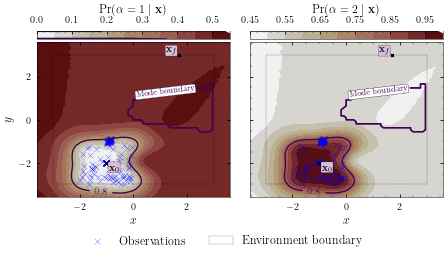

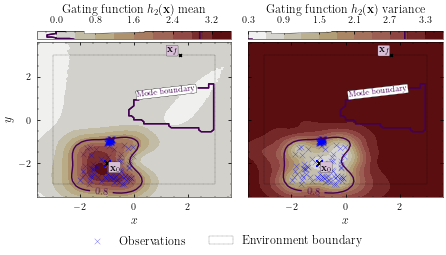

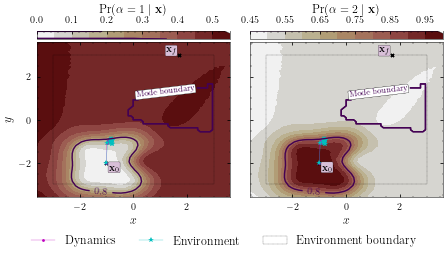

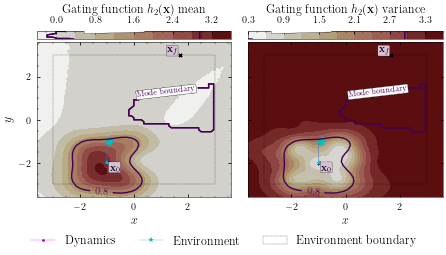

Epoch 1/10000
Mixing probs: (1, None, 2)
Instructions for updating:
Use fn_output_signature instead
Experts probs: (None, None, 2)
Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
1/1 [==============================] - ETA: 0s - loss: -654.1383Mixing probs: (1, None, 2)
Experts probs: (None, None, 2)
1/1 [==============================] - 23s 23s/step - loss: -654.1383 - val_loss: -628.3441
Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-11-15-49/ckpts/step_1_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -528.5684

2022-04-11 15:53:19.490907: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-11 15:53:19.490927: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-11 15:53:19.514754: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-11 15:53:19.569957: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-11 15:53:19.595836: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_15_53_19

2022-04-11 15:53:19.629382: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_15_53_19/dr-robots-mbp.local.trace.json.gz


1/1 [==============================] - 0s 295ms/step - loss: -528.5684 - val_loss: -586.6362
Epoch 3/10000
1/1 [==============================] - 0s 70ms/step - loss: -629.4254 - val_loss: -668.5885
Epoch 4/10000
1/1 [==============================] - ETA: 0s - loss: -643.9472

2022-04-11 15:53:19.727309: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_15_53_19

2022-04-11 15:53:19.727760: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_15_53_19/dr-robots-mbp.local.memory_profile.json.gz
2022-04-11 15:53:19.743191: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_15_53_19
Dumped tool data for xplane.pb to ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_15_53_19/dr-robots-mbp.local.xplane.pb
Dumped tool data for overview_page.pb to ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profi

1/1 [==============================] - 0s 61ms/step - loss: -643.9472 - val_loss: -649.0902
Epoch 5/10000
1/1 [==============================] - 0s 55ms/step - loss: -628.2866 - val_loss: -669.1793
Epoch 6/10000
1/1 [==============================] - 0s 83ms/step - loss: -628.9061 - val_loss: -606.7202
Epoch 7/10000
1/1 [==============================] - 0s 69ms/step - loss: -588.2658 - val_loss: -655.4800
Epoch 8/10000
1/1 [==============================] - 0s 58ms/step - loss: -646.8900 - val_loss: -679.8324
Epoch 9/10000
1/1 [==============================] - 0s 60ms/step - loss: -663.8235 - val_loss: -674.8279
Epoch 10/10000
1/1 [==============================] - 0s 82ms/step - loss: -669.0316 - val_loss: -721.7816
Epoch 11/10000
1/1 [==============================] - 0s 84ms/step - loss: -629.1139 - val_loss: -685.1121
Epoch 12/10000
1/1 [==============================] - 0s 59ms/step - loss: -632.9286 - val_loss: -677.4140
Epoch 13/10000
1/1 [==============================] - 0s 

Epoch 81/10000
1/1 [==============================] - 0s 73ms/step - loss: -704.2020 - val_loss: -783.6940
Epoch 82/10000
1/1 [==============================] - 0s 54ms/step - loss: -733.4583 - val_loss: -829.7665
Epoch 83/10000
1/1 [==============================] - 0s 71ms/step - loss: -713.1108 - val_loss: -740.1495
Epoch 84/10000
1/1 [==============================] - 0s 94ms/step - loss: -724.0191 - val_loss: -752.2964
Epoch 85/10000
1/1 [==============================] - 0s 116ms/step - loss: -723.8636 - val_loss: -822.1757
Epoch 86/10000
1/1 [==============================] - 0s 74ms/step - loss: -519.4090 - val_loss: -764.0584
Epoch 87/10000
1/1 [==============================] - 0s 72ms/step - loss: -710.7191 - val_loss: -722.6184
Epoch 88/10000
1/1 [==============================] - 0s 68ms/step - loss: -780.8501 - val_loss: -829.8860
Epoch 89/10000
1/1 [==============================] - 0s 85ms/step - loss: -529.9312 - val_loss: -721.0106
Epoch 90/10000
1/1 [================

1/1 [==============================] - 0s 74ms/step - loss: -229.2864 - val_loss: 328.0068
Epoch 158/10000
1/1 [==============================] - 0s 55ms/step - loss: -498.5551 - val_loss: -592.6514
Epoch 159/10000
1/1 [==============================] - 0s 60ms/step - loss: -395.8696 - val_loss: -149.1992
Epoch 160/10000
1/1 [==============================] - 0s 66ms/step - loss: -371.9705 - val_loss: -591.2033
Epoch 161/10000
1/1 [==============================] - 0s 54ms/step - loss: -480.0491 - val_loss: -599.8983
Epoch 162/10000
1/1 [==============================] - 0s 56ms/step - loss: -307.1125 - val_loss: 360.6939
Epoch 163/10000
1/1 [==============================] - 0s 80ms/step - loss: -261.2483 - val_loss: 515.0784
Epoch 164/10000
1/1 [==============================] - 0s 82ms/step - loss: -264.3036 - val_loss: -357.8376
Epoch 165/10000
1/1 [==============================] - 0s 58ms/step - loss: -228.2188 - val_loss: 17.9279
Epoch 166/10000
1/1 [============================

1/1 [==============================] - 0s 67ms/step - loss: -653.4125 - val_loss: -696.8579
Epoch 234/10000
1/1 [==============================] - 0s 67ms/step - loss: -631.1169 - val_loss: -719.0934
Epoch 235/10000
1/1 [==============================] - 0s 49ms/step - loss: -611.4481 - val_loss: -646.0392
Epoch 236/10000
1/1 [==============================] - 0s 68ms/step - loss: -576.9540 - val_loss: -721.6636
Epoch 237/10000
1/1 [==============================] - 0s 61ms/step - loss: -664.6678 - val_loss: -719.4098
Epoch 238/10000
1/1 [==============================] - 0s 45ms/step - loss: -668.2412 - val_loss: -729.7021
Epoch 239/10000
1/1 [==============================] - 0s 59ms/step - loss: -623.4440 - val_loss: -720.6669
Epoch 240/10000
1/1 [==============================] - 0s 70ms/step - loss: -655.4084 - val_loss: -740.9703
Epoch 241/10000
1/1 [==============================] - 0s 65ms/step - loss: -638.6560 - val_loss: -737.3745
Epoch 242/10000
1/1 [=======================

1/1 [==============================] - 0s 50ms/step - loss: -711.4634 - val_loss: -797.3022
Epoch 310/10000
1/1 [==============================] - 0s 54ms/step - loss: -560.4377 - val_loss: -800.6888
Epoch 311/10000
1/1 [==============================] - 0s 63ms/step - loss: -693.6884 - val_loss: -789.1196
Epoch 312/10000
1/1 [==============================] - 0s 53ms/step - loss: -567.1946 - val_loss: -807.9777
Epoch 313/10000
1/1 [==============================] - 0s 48ms/step - loss: -716.9187 - val_loss: -813.4412
Epoch 314/10000
1/1 [==============================] - 0s 66ms/step - loss: -637.9276 - val_loss: -814.7740
Epoch 315/10000
1/1 [==============================] - 0s 78ms/step - loss: -721.0375 - val_loss: -716.0461
Epoch 316/10000
1/1 [==============================] - 0s 58ms/step - loss: -541.7323 - val_loss: -715.1623
Epoch 317/10000
1/1 [==============================] - 0s 53ms/step - loss: -603.1506 - val_loss: -757.2904
Epoch 318/10000
1/1 [=======================

1/1 [==============================] - 0s 79ms/step - loss: -579.1091 - val_loss: -668.8418
Epoch 386/10000
1/1 [==============================] - 0s 60ms/step - loss: -83.7622 - val_loss: -414.6633
Epoch 387/10000
1/1 [==============================] - 0s 51ms/step - loss: -274.2298 - val_loss: -294.9753
Epoch 388/10000
1/1 [==============================] - 0s 65ms/step - loss: -250.2175 - val_loss: -423.0682
Epoch 389/10000
1/1 [==============================] - 0s 60ms/step - loss: -408.7935 - val_loss: -610.5859
Epoch 390/10000
1/1 [==============================] - 0s 51ms/step - loss: -332.9216 - val_loss: -598.3103
Epoch 391/10000
1/1 [==============================] - 0s 67ms/step - loss: -522.7620 - val_loss: -649.0682
Epoch 392/10000
1/1 [==============================] - 0s 55ms/step - loss: -239.8926 - val_loss: -369.5271
Epoch 393/10000
1/1 [==============================] - 0s 52ms/step - loss: -245.6622 - val_loss: -485.3642
Epoch 394/10000
1/1 [========================

Epoch 461/10000
1/1 [==============================] - 0s 49ms/step - loss: -689.7765 - val_loss: -750.1468
Epoch 462/10000
1/1 [==============================] - 0s 77ms/step - loss: -669.2255 - val_loss: -688.5263
Epoch 463/10000
1/1 [==============================] - 0s 82ms/step - loss: -693.4724 - val_loss: -748.0061
Epoch 464/10000
1/1 [==============================] - 0s 53ms/step - loss: -695.0439 - val_loss: -757.6187
Epoch 465/10000
1/1 [==============================] - 0s 58ms/step - loss: -682.1591 - val_loss: -748.8388
Epoch 466/10000
1/1 [==============================] - 0s 78ms/step - loss: -687.4439 - val_loss: -762.9940
Epoch 467/10000
1/1 [==============================] - 0s 62ms/step - loss: -712.3871 - val_loss: -767.8033
Epoch 468/10000
1/1 [==============================] - 0s 52ms/step - loss: -712.3725 - val_loss: -768.7182
Epoch 469/10000
1/1 [==============================] - 0s 69ms/step - loss: -700.3006 - val_loss: -741.2991
Epoch 470/10000
1/1 [=======

1/1 [==============================] - 0s 55ms/step - loss: -775.7701 - val_loss: -874.4039
Epoch 537/10000
1/1 [==============================] - 0s 64ms/step - loss: -807.9196 - val_loss: -873.7227
Epoch 538/10000
1/1 [==============================] - 0s 63ms/step - loss: -641.8429 - val_loss: -776.7737
Epoch 539/10000
1/1 [==============================] - 0s 75ms/step - loss: -582.0845 - val_loss: -588.0368
Epoch 540/10000
1/1 [==============================] - 0s 95ms/step - loss: -555.5069 - val_loss: -431.3963
Epoch 541/10000
1/1 [==============================] - 0s 78ms/step - loss: -744.8825 - val_loss: -760.4437
Epoch 542/10000
1/1 [==============================] - 0s 54ms/step - loss: -735.4139 - val_loss: -789.7424
Epoch 543/10000
1/1 [==============================] - 0s 68ms/step - loss: -189.5001 - val_loss: -296.6640
Epoch 544/10000
1/1 [==============================] - 0s 91ms/step - loss: -791.3865 - val_loss: -794.9435
Epoch 545/10000
1/1 [=======================

1/1 [==============================] - 0s 42ms/step - loss: -527.6504 - val_loss: -686.4707
Epoch 613/10000
1/1 [==============================] - 0s 60ms/step - loss: -632.2289 - val_loss: -718.7138
Epoch 614/10000
1/1 [==============================] - 0s 64ms/step - loss: 84.4021 - val_loss: -620.9197
Epoch 615/10000
1/1 [==============================] - 0s 54ms/step - loss: -436.0464 - val_loss: -719.6816
Epoch 616/10000
1/1 [==============================] - 0s 73ms/step - loss: -144.3109 - val_loss: -615.1931
Epoch 617/10000
1/1 [==============================] - 0s 81ms/step - loss: -394.4937 - val_loss: -602.8855
Epoch 618/10000
1/1 [==============================] - 0s 88ms/step - loss: -635.9255 - val_loss: -665.0100
Epoch 619/10000
1/1 [==============================] - 0s 62ms/step - loss: -584.7895 - val_loss: -730.9718
Epoch 620/10000
1/1 [==============================] - 0s 65ms/step - loss: -367.5154 - val_loss: -725.3193
Epoch 621/10000
1/1 [=========================

Epoch 688/10000
1/1 [==============================] - 0s 164ms/step - loss: -680.8315 - val_loss: -776.2814
Epoch 689/10000
1/1 [==============================] - 0s 117ms/step - loss: -703.6693 - val_loss: -783.2560
Epoch 690/10000
1/1 [==============================] - 0s 88ms/step - loss: -737.7773 - val_loss: -814.8431
Epoch 691/10000
1/1 [==============================] - 0s 95ms/step - loss: -699.4795 - val_loss: -793.9339
Epoch 692/10000
1/1 [==============================] - 0s 90ms/step - loss: -620.5731 - val_loss: -778.1994
Epoch 693/10000
1/1 [==============================] - 0s 75ms/step - loss: -722.6170 - val_loss: -817.9386
Epoch 694/10000
1/1 [==============================] - 0s 169ms/step - loss: -746.6709 - val_loss: -765.2247
Epoch 695/10000
1/1 [==============================] - 0s 159ms/step - loss: -714.0792 - val_loss: -719.7155
Epoch 696/10000
1/1 [==============================] - 0s 149ms/step - loss: -743.3010 - val_loss: -821.5424
Epoch 697/10000
1/1 [==

Epoch 764/10000
1/1 [==============================] - 0s 82ms/step - loss: -599.3280 - val_loss: -876.6084
Epoch 765/10000
1/1 [==============================] - 0s 52ms/step - loss: -458.6959 - val_loss: -552.7996
Epoch 766/10000
1/1 [==============================] - 0s 69ms/step - loss: -634.1753 - val_loss: -867.2648
Epoch 767/10000
1/1 [==============================] - 0s 83ms/step - loss: -377.0864 - val_loss: -268.6247
Epoch 768/10000
1/1 [==============================] - 0s 70ms/step - loss: -341.4612 - val_loss: -876.5552
Epoch 769/10000
1/1 [==============================] - 0s 57ms/step - loss: -696.1146 - val_loss: -486.6967
Epoch 770/10000
1/1 [==============================] - 0s 74ms/step - loss: -746.7719 - val_loss: -757.3993
Epoch 771/10000
1/1 [==============================] - ETA: 0s - loss: -718.35 - 0s 64ms/step - loss: -718.3513 - val_loss: -802.4282
Epoch 772/10000
1/1 [==============================] - 0s 51ms/step - loss: -232.4288 - val_loss: -333.5908
Ep

Epoch 840/10000
1/1 [==============================] - 0s 73ms/step - loss: -544.8266 - val_loss: -634.8217
Epoch 841/10000
1/1 [==============================] - 0s 49ms/step - loss: -644.6425 - val_loss: -727.8450
Epoch 842/10000
1/1 [==============================] - 0s 48ms/step - loss: -604.7186 - val_loss: -714.0957
Epoch 843/10000
1/1 [==============================] - 0s 47ms/step - loss: -644.2618 - val_loss: -719.1137
Epoch 844/10000
1/1 [==============================] - 0s 52ms/step - loss: -656.6342 - val_loss: -740.3540
Epoch 845/10000
1/1 [==============================] - 0s 50ms/step - loss: -659.2191 - val_loss: -707.7848
Epoch 846/10000
1/1 [==============================] - 0s 51ms/step - loss: -619.1852 - val_loss: -674.2521
Epoch 847/10000
1/1 [==============================] - 0s 51ms/step - loss: -670.4265 - val_loss: -743.3964
Epoch 848/10000
1/1 [==============================] - 0s 46ms/step - loss: -649.5865 - val_loss: -725.9755
Epoch 849/10000
1/1 [=======

1/1 [==============================] - 0s 47ms/step - loss: -795.0636 - val_loss: -848.9891
Epoch 916/10000
1/1 [==============================] - 0s 46ms/step - loss: -777.8706 - val_loss: -862.5202
Epoch 917/10000
1/1 [==============================] - 0s 46ms/step - loss: -771.3680 - val_loss: -851.5175
Epoch 918/10000
1/1 [==============================] - 0s 48ms/step - loss: -758.8562 - val_loss: -846.1304
Epoch 919/10000
1/1 [==============================] - 0s 49ms/step - loss: -784.2474 - val_loss: -852.2299
Epoch 920/10000
1/1 [==============================] - 0s 47ms/step - loss: -774.9372 - val_loss: -852.4146
Epoch 921/10000
1/1 [==============================] - 0s 48ms/step - loss: -773.0377 - val_loss: -836.0015
Epoch 922/10000
1/1 [==============================] - 0s 47ms/step - loss: -770.9425 - val_loss: -822.0702
Epoch 923/10000
1/1 [==============================] - 0s 47ms/step - loss: -788.1568 - val_loss: -858.5539
Epoch 924/10000
1/1 [=======================

Epoch 991/10000
1/1 [==============================] - 0s 49ms/step - loss: -441.6213 - val_loss: -752.4558
Epoch 992/10000
1/1 [==============================] - 0s 48ms/step - loss: -428.3356 - val_loss: -624.7369
Epoch 993/10000
1/1 [==============================] - 0s 48ms/step - loss: -276.2731 - val_loss: -567.2238
Epoch 994/10000
1/1 [==============================] - 0s 47ms/step - loss: -641.0132 - val_loss: -788.8353
Epoch 995/10000
1/1 [==============================] - 0s 52ms/step - loss: -605.2324 - val_loss: -659.2894
Epoch 996/10000
1/1 [==============================] - 0s 55ms/step - loss: -757.1843 - val_loss: -835.3269
Epoch 997/10000
1/1 [==============================] - 0s 48ms/step - loss: -571.1702 - val_loss: -822.3777
Epoch 998/10000
1/1 [==============================] - 0s 48ms/step - loss: -683.3292 - val_loss: -716.4131
Epoch 999/10000
1/1 [==============================] - 0s 47ms/step - loss: -719.7255 - val_loss: -783.4666
Epoch 1000/10000
1/1 [======

1/1 [==============================] - 0s 52ms/step - loss: -676.8459 - val_loss: -680.5038
Epoch 1067/10000
1/1 [==============================] - 0s 51ms/step - loss: -674.5451 - val_loss: -744.8450
Epoch 1068/10000
1/1 [==============================] - 0s 49ms/step - loss: -594.3643 - val_loss: -697.8211
Epoch 1069/10000
1/1 [==============================] - 0s 50ms/step - loss: -689.6927 - val_loss: -758.1488
Epoch 1070/10000
1/1 [==============================] - 0s 57ms/step - loss: -678.8095 - val_loss: -744.6995
Epoch 1071/10000
1/1 [==============================] - 0s 54ms/step - loss: -644.9586 - val_loss: -751.9600
Epoch 1072/10000
1/1 [==============================] - 0s 52ms/step - loss: -706.8329 - val_loss: -779.7714
Epoch 1073/10000
1/1 [==============================] - 0s 48ms/step - loss: -667.4993 - val_loss: -681.3801
Epoch 1074/10000
1/1 [==============================] - 0s 50ms/step - loss: -636.8929 - val_loss: -721.2250
Epoch 1075/10000
1/1 [==============

1/1 [==============================] - 0s 52ms/step - loss: -758.0418 - val_loss: -861.4063
Epoch 1142/10000
1/1 [==============================] - 0s 45ms/step - loss: -799.2238 - val_loss: -861.7278
Epoch 1143/10000
1/1 [==============================] - 0s 48ms/step - loss: -787.5982 - val_loss: -843.6695
Epoch 1144/10000
1/1 [==============================] - 0s 46ms/step - loss: -780.8535 - val_loss: -863.4394
Epoch 1145/10000
1/1 [==============================] - 0s 44ms/step - loss: -802.6017 - val_loss: -854.6858
Epoch 1146/10000
1/1 [==============================] - 0s 53ms/step - loss: -798.2433 - val_loss: -818.5890
Epoch 1147/10000
1/1 [==============================] - 0s 53ms/step - loss: -782.5976 - val_loss: -804.9831
Epoch 1148/10000
1/1 [==============================] - 0s 44ms/step - loss: -524.8618 - val_loss: -844.0412
Epoch 1149/10000
1/1 [==============================] - 0s 44ms/step - loss: -771.9510 - val_loss: -665.0587
Epoch 1150/10000
1/1 [==============

1/1 [==============================] - 0s 45ms/step - loss: -684.1440 - val_loss: -732.5142
Epoch 1217/10000
1/1 [==============================] - 0s 42ms/step - loss: -670.5857 - val_loss: -728.8537
Epoch 1218/10000
1/1 [==============================] - 0s 44ms/step - loss: -661.8455 - val_loss: -725.7541
Epoch 1219/10000
1/1 [==============================] - 0s 42ms/step - loss: -713.6868 - val_loss: -769.9450
Epoch 1220/10000
1/1 [==============================] - 0s 43ms/step - loss: -720.9567 - val_loss: -772.1392
Epoch 1221/10000
1/1 [==============================] - 0s 59ms/step - loss: -721.2263 - val_loss: -778.2792
Epoch 1222/10000
1/1 [==============================] - 0s 68ms/step - loss: -685.8953 - val_loss: -713.6903
Epoch 1223/10000
1/1 [==============================] - 0s 64ms/step - loss: -715.0740 - val_loss: -760.6317
Epoch 1224/10000
1/1 [==============================] - 0s 62ms/step - loss: -707.3321 - val_loss: -762.3156
Epoch 1225/10000
1/1 [==============

1/1 [==============================] - 0s 40ms/step - loss: -696.3154 - val_loss: -759.1375
Epoch 1292/10000
1/1 [==============================] - 0s 39ms/step - loss: -772.1531 - val_loss: -806.7457
Epoch 1293/10000
1/1 [==============================] - 0s 40ms/step - loss: -795.9069 - val_loss: -820.2730
Epoch 1294/10000
1/1 [==============================] - 0s 41ms/step - loss: -789.1023 - val_loss: -862.4690
Epoch 1295/10000
1/1 [==============================] - 0s 40ms/step - loss: -684.2265 - val_loss: -687.3307
Epoch 1296/10000
1/1 [==============================] - 0s 40ms/step - loss: -680.2095 - val_loss: -751.8091
Epoch 1297/10000
1/1 [==============================] - 0s 40ms/step - loss: -731.2202 - val_loss: -778.6641
Epoch 1298/10000
1/1 [==============================] - 0s 40ms/step - loss: -769.2598 - val_loss: -829.3846
Epoch 1299/10000
1/1 [==============================] - 0s 40ms/step - loss: -433.8839 - val_loss: -490.5279
Epoch 1300/10000
1/1 [==============

1/1 [==============================] - 0s 50ms/step - loss: -174.6272 - val_loss: -680.4584
Epoch 1367/10000
1/1 [==============================] - 0s 70ms/step - loss: -566.7068 - val_loss: -634.2920
Epoch 1368/10000
1/1 [==============================] - 0s 48ms/step - loss: -482.7648 - val_loss: -410.8869
Epoch 1369/10000
1/1 [==============================] - 0s 51ms/step - loss: -625.9645 - val_loss: -663.0212
Epoch 1370/10000
1/1 [==============================] - 0s 46ms/step - loss: -651.0955 - val_loss: -727.1640
Epoch 1371/10000
1/1 [==============================] - 0s 50ms/step - loss: -494.1471 - val_loss: -579.5415
Epoch 1372/10000
1/1 [==============================] - 0s 49ms/step - loss: -496.1651 - val_loss: -464.8088
Epoch 1373/10000
1/1 [==============================] - 0s 48ms/step - loss: -552.5762 - val_loss: -574.2921
Epoch 1374/10000
1/1 [==============================] - 0s 54ms/step - loss: -501.8124 - val_loss: -660.6269
Epoch 1375/10000
1/1 [==============

1/1 [==============================] - 0s 38ms/step - loss: -572.9859 - val_loss: -761.6939
Epoch 1442/10000
1/1 [==============================] - 0s 37ms/step - loss: -474.8983 - val_loss: -541.6904
Epoch 1443/10000
1/1 [==============================] - 0s 38ms/step - loss: -449.1149 - val_loss: -586.5929
Epoch 1444/10000
1/1 [==============================] - 0s 38ms/step - loss: -533.5024 - val_loss: -706.9704
Epoch 1445/10000
1/1 [==============================] - 0s 38ms/step - loss: -373.0685 - val_loss: -452.7422
Epoch 1446/10000
1/1 [==============================] - 0s 38ms/step - loss: -633.7542 - val_loss: -763.7135
Epoch 1447/10000
1/1 [==============================] - 0s 37ms/step - loss: -494.5444 - val_loss: -770.7703
Epoch 1448/10000
1/1 [==============================] - 0s 38ms/step - loss: -649.1981 - val_loss: -750.1869
Epoch 1449/10000
1/1 [==============================] - 0s 37ms/step - loss: -639.2128 - val_loss: -742.8329
Epoch 1450/10000
1/1 [==============

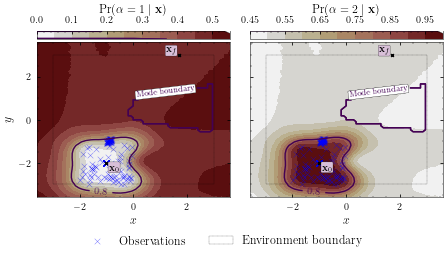

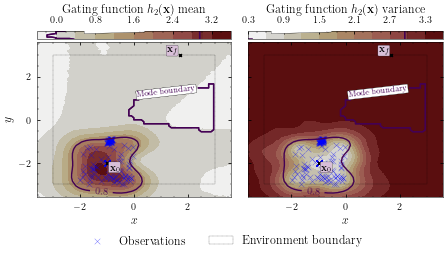

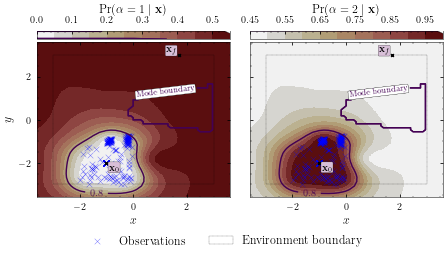

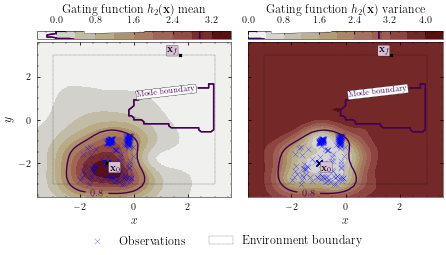

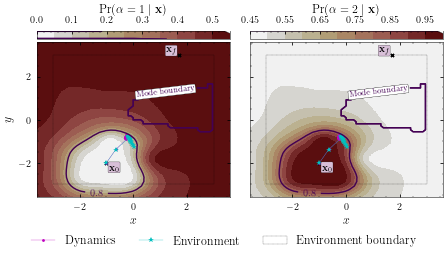

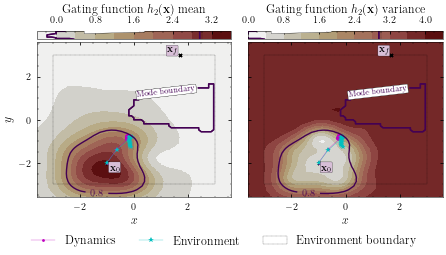

Epoch 1/10000
1/1 [==============================] - 1s 631ms/step - loss: -320.3162 - val_loss: 101.7474
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-11-15-49/ckpts/step_2_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -691.1304

2022-04-11 15:57:00.753030: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-11 15:57:00.753065: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 3s 3s/step - loss: -691.1304 - val_loss: -611.4991


2022-04-11 15:57:03.318373: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-11 15:57:03.338748: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-11 15:57:03.370609: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_15_57_03

2022-04-11 15:57:03.394219: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_15_57_03/dr-robots-mbp.local.trace.json.gz
2022-04-11 15:57:03.433003: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_15_57_03

2022-04-11 15:57:03.436035: I tensorflow/core/profiler/rpc/client/save_profile.

Epoch 3/10000
1/1 [==============================] - 0s 72ms/step - loss: -644.0693 - val_loss: -707.1616
Epoch 4/10000
1/1 [==============================] - 0s 57ms/step - loss: -645.1235 - val_loss: -746.2872
Epoch 5/10000
1/1 [==============================] - 0s 61ms/step - loss: -456.4548 - val_loss: -414.4558
Epoch 6/10000
1/1 [==============================] - 0s 67ms/step - loss: -667.0854 - val_loss: -749.7403
Epoch 7/10000
1/1 [==============================] - 0s 62ms/step - loss: -389.7401 - val_loss: -684.1933
Epoch 8/10000
1/1 [==============================] - 0s 50ms/step - loss: -492.3584 - val_loss: -439.0308
Epoch 9/10000
1/1 [==============================] - 0s 68ms/step - loss: -679.1530 - val_loss: -658.1573
Epoch 10/10000
1/1 [==============================] - 0s 62ms/step - loss: -322.2683 - val_loss: -147.2726
Epoch 11/10000
1/1 [==============================] - 0s 50ms/step - loss: -407.7504 - val_loss: -557.0326
Epoch 12/10000
1/1 [========================

Epoch 80/10000
1/1 [==============================] - 0s 57ms/step - loss: -563.8755 - val_loss: -639.8601
Epoch 81/10000
1/1 [==============================] - 0s 66ms/step - loss: -605.3468 - val_loss: -651.1539
Epoch 82/10000
1/1 [==============================] - 0s 58ms/step - loss: -602.1165 - val_loss: -551.5313
Epoch 83/10000
1/1 [==============================] - 0s 57ms/step - loss: -541.4690 - val_loss: -518.9713
Epoch 84/10000
1/1 [==============================] - 0s 64ms/step - loss: -476.2183 - val_loss: -581.1780
Epoch 85/10000
1/1 [==============================] - 0s 75ms/step - loss: -623.8104 - val_loss: -631.3328
Epoch 86/10000
1/1 [==============================] - 0s 66ms/step - loss: -541.1983 - val_loss: -643.6613
Epoch 87/10000
1/1 [==============================] - 0s 53ms/step - loss: -578.9283 - val_loss: -636.1177
Epoch 88/10000
1/1 [==============================] - 0s 59ms/step - loss: -500.7565 - val_loss: -671.0994
Epoch 89/10000
1/1 [=================

Epoch 156/10000
1/1 [==============================] - 0s 61ms/step - loss: -594.6110 - val_loss: -415.3785
Epoch 157/10000
1/1 [==============================] - 0s 46ms/step - loss: -729.6588 - val_loss: -732.0838
Epoch 158/10000
1/1 [==============================] - 0s 67ms/step - loss: -697.3557 - val_loss: -702.2903
Epoch 159/10000
1/1 [==============================] - 0s 76ms/step - loss: -723.5576 - val_loss: -790.1248
Epoch 160/10000
1/1 [==============================] - 0s 64ms/step - loss: -633.0992 - val_loss: -691.1874
Epoch 161/10000
1/1 [==============================] - 0s 45ms/step - loss: -600.2176 - val_loss: -199.6361
Epoch 162/10000
1/1 [==============================] - 0s 69ms/step - loss: -724.5196 - val_loss: -770.2023
Epoch 163/10000
1/1 [==============================] - 0s 70ms/step - loss: -731.4042 - val_loss: -659.9236
Epoch 164/10000
1/1 [==============================] - 0s 50ms/step - loss: -566.5385 - val_loss: -226.3765
Epoch 165/10000
1/1 [=======

1/1 [==============================] - 0s 59ms/step - loss: -758.5324 - val_loss: -805.3941
Epoch 232/10000
1/1 [==============================] - 0s 56ms/step - loss: -778.6583 - val_loss: -833.5011
Epoch 233/10000
1/1 [==============================] - 0s 77ms/step - loss: -700.9331 - val_loss: -714.4334
Epoch 234/10000
1/1 [==============================] - 0s 71ms/step - loss: -714.9896 - val_loss: -679.9089
Epoch 235/10000
1/1 [==============================] - 0s 66ms/step - loss: -751.7083 - val_loss: -736.3146
Epoch 236/10000
1/1 [==============================] - 0s 63ms/step - loss: -755.0855 - val_loss: -774.5012
Epoch 237/10000
1/1 [==============================] - 0s 67ms/step - loss: -758.8550 - val_loss: -828.9160
Epoch 238/10000
1/1 [==============================] - 0s 83ms/step - loss: -757.9780 - val_loss: -871.6179
Epoch 239/10000
1/1 [==============================] - 0s 84ms/step - loss: -787.1811 - val_loss: -866.1403
Epoch 240/10000
1/1 [=======================

1/1 [==============================] - 0s 64ms/step - loss: -519.6102 - val_loss: -774.6889
Epoch 308/10000
1/1 [==============================] - 0s 73ms/step - loss: -172.4037 - val_loss: -649.7773
Epoch 309/10000
1/1 [==============================] - 0s 82ms/step - loss: -211.2712 - val_loss: -596.5023
Epoch 310/10000
1/1 [==============================] - 0s 68ms/step - loss: -359.7540 - val_loss: -603.1953
Epoch 311/10000
1/1 [==============================] - 0s 50ms/step - loss: -346.9457 - val_loss: -199.9433
Epoch 312/10000
1/1 [==============================] - 0s 62ms/step - loss: -245.7086 - val_loss: -734.8266
Epoch 313/10000
1/1 [==============================] - 0s 73ms/step - loss: -165.1558 - val_loss: -394.6971
Epoch 314/10000
1/1 [==============================] - 0s 58ms/step - loss: -137.3736 - val_loss: -475.2296
Epoch 315/10000
1/1 [==============================] - 0s 55ms/step - loss: -505.2993 - val_loss: -651.6093
Epoch 316/10000
1/1 [=======================

1/1 [==============================] - 0s 72ms/step - loss: -706.2094 - val_loss: -705.4808
Epoch 384/10000
1/1 [==============================] - 0s 78ms/step - loss: -683.9114 - val_loss: -702.3024
Epoch 385/10000
1/1 [==============================] - 0s 54ms/step - loss: -683.4182 - val_loss: -789.8820
Epoch 386/10000
1/1 [==============================] - 0s 59ms/step - loss: -699.5578 - val_loss: -769.3573
Epoch 387/10000
1/1 [==============================] - 0s 68ms/step - loss: -694.9821 - val_loss: -809.6498
Epoch 388/10000
1/1 [==============================] - 0s 57ms/step - loss: -715.8604 - val_loss: -756.6716
Epoch 389/10000
1/1 [==============================] - 0s 51ms/step - loss: -741.3562 - val_loss: -814.8452
Epoch 390/10000
1/1 [==============================] - 0s 76ms/step - loss: -721.7203 - val_loss: -822.9714
Epoch 391/10000
1/1 [==============================] - 0s 77ms/step - loss: -692.8344 - val_loss: -736.4257
Epoch 392/10000
1/1 [=======================

Epoch 459/10000
1/1 [==============================] - 0s 53ms/step - loss: -669.6946 - val_loss: -739.4308
Epoch 460/10000
1/1 [==============================] - 0s 85ms/step - loss: -746.6916 - val_loss: -829.2691
Epoch 461/10000
1/1 [==============================] - 0s 116ms/step - loss: -730.3482 - val_loss: -853.2224
Epoch 462/10000
1/1 [==============================] - 0s 62ms/step - loss: -719.8208 - val_loss: -882.6344
Epoch 463/10000
1/1 [==============================] - 0s 68ms/step - loss: -632.4776 - val_loss: -862.4609
Epoch 464/10000
1/1 [==============================] - 0s 87ms/step - loss: -790.8103 - val_loss: -826.4813
Epoch 465/10000
1/1 [==============================] - 0s 89ms/step - loss: -708.7134 - val_loss: -724.2020
Epoch 466/10000
1/1 [==============================] - 0s 88ms/step - loss: -645.9995 - val_loss: -783.5951
Epoch 467/10000
1/1 [==============================] - 0s 54ms/step - loss: -763.3384 - val_loss: -863.3496
Epoch 468/10000
1/1 [======

Epoch 535/10000
1/1 [==============================] - 0s 56ms/step - loss: -710.2935 - val_loss: -868.7552
Epoch 536/10000
1/1 [==============================] - 0s 58ms/step - loss: -753.6527 - val_loss: -694.6582
Epoch 537/10000
1/1 [==============================] - 0s 57ms/step - loss: -813.3887 - val_loss: -851.5367
Epoch 538/10000
1/1 [==============================] - 0s 58ms/step - loss: -736.5628 - val_loss: -870.7550
Epoch 539/10000
1/1 [==============================] - 0s 59ms/step - loss: -743.7119 - val_loss: -862.4956
Epoch 540/10000
1/1 [==============================] - 0s 65ms/step - loss: -579.9598 - val_loss: -724.0206
Epoch 541/10000
1/1 [==============================] - 0s 86ms/step - loss: -785.7316 - val_loss: -874.8971
Epoch 542/10000
1/1 [==============================] - 0s 57ms/step - loss: -790.6113 - val_loss: -826.5858
Epoch 543/10000
1/1 [==============================] - 0s 57ms/step - loss: -799.0677 - val_loss: -846.7862
Epoch 544/10000
1/1 [=======

Epoch 611/10000
1/1 [==============================] - 0s 41ms/step - loss: -450.1403 - val_loss: -683.3802
Epoch 612/10000
1/1 [==============================] - 0s 42ms/step - loss: -620.6643 - val_loss: -829.4750
Epoch 613/10000
1/1 [==============================] - 0s 43ms/step - loss: -3.5577 - val_loss: 184.4801
Epoch 614/10000
1/1 [==============================] - 0s 43ms/step - loss: -371.1314 - val_loss: -650.7002
Epoch 615/10000
1/1 [==============================] - 0s 42ms/step - loss: -409.2551 - val_loss: -626.5282
Epoch 616/10000
1/1 [==============================] - 0s 41ms/step - loss: -669.2439 - val_loss: -781.8476
Epoch 617/10000
1/1 [==============================] - 0s 42ms/step - loss: -565.0565 - val_loss: -680.0015
Epoch 618/10000
1/1 [==============================] - 0s 43ms/step - loss: -317.7986 - val_loss: -82.0763
Epoch 619/10000
1/1 [==============================] - 0s 40ms/step - loss: 417.0766 - val_loss: 691.7670
Epoch 620/10000
1/1 [=============

Epoch 687/10000
1/1 [==============================] - 0s 43ms/step - loss: -698.6499 - val_loss: -725.3818
Epoch 688/10000
1/1 [==============================] - 0s 45ms/step - loss: -695.8722 - val_loss: -701.7123
Epoch 689/10000
1/1 [==============================] - 0s 43ms/step - loss: -739.4384 - val_loss: -770.8063
Epoch 690/10000
1/1 [==============================] - 0s 43ms/step - loss: -707.5597 - val_loss: -741.9628
Epoch 691/10000
1/1 [==============================] - 0s 42ms/step - loss: -735.3060 - val_loss: -777.4483
Epoch 692/10000
1/1 [==============================] - 0s 47ms/step - loss: -719.9209 - val_loss: -768.8407
Epoch 693/10000
1/1 [==============================] - 0s 43ms/step - loss: -735.6941 - val_loss: -751.9575
Epoch 694/10000
1/1 [==============================] - 0s 53ms/step - loss: -638.6949 - val_loss: -737.3251
Epoch 695/10000
1/1 [==============================] - 0s 54ms/step - loss: -724.4898 - val_loss: -773.2254
Epoch 696/10000
1/1 [=======

Epoch 763/10000
1/1 [==============================] - 0s 41ms/step - loss: -732.8350 - val_loss: -856.1055
Epoch 764/10000
1/1 [==============================] - 0s 43ms/step - loss: -645.5639 - val_loss: -848.0330
Epoch 765/10000
1/1 [==============================] - 0s 43ms/step - loss: -627.6532 - val_loss: -818.5171
Epoch 766/10000
1/1 [==============================] - 0s 51ms/step - loss: -733.7347 - val_loss: -753.3959
Epoch 767/10000
1/1 [==============================] - 0s 50ms/step - loss: -553.2408 - val_loss: -707.2137
Epoch 768/10000
1/1 [==============================] - 0s 43ms/step - loss: -382.4791 - val_loss: -868.4463
Epoch 769/10000
1/1 [==============================] - 0s 45ms/step - loss: -787.3057 - val_loss: -789.9387
Epoch 770/10000
1/1 [==============================] - 0s 43ms/step - loss: -760.7720 - val_loss: -810.4888
Epoch 771/10000
1/1 [==============================] - 0s 42ms/step - loss: -638.6497 - val_loss: -664.8206
Epoch 772/10000
1/1 [=======

Epoch 839/10000
1/1 [==============================] - 0s 41ms/step - loss: -818.3281 - val_loss: -845.7523
Epoch 840/10000
1/1 [==============================] - 0s 43ms/step - loss: -610.0002 - val_loss: -623.7146
Epoch 841/10000
1/1 [==============================] - 0s 49ms/step - loss: -803.6898 - val_loss: -880.3913
Epoch 842/10000
1/1 [==============================] - 0s 51ms/step - loss: -720.1474 - val_loss: -708.3838
Epoch 843/10000
1/1 [==============================] - 0s 48ms/step - loss: -415.3873 - val_loss: -745.4678
Epoch 844/10000
1/1 [==============================] - 0s 44ms/step - loss: -779.8019 - val_loss: -806.1893
Epoch 845/10000
1/1 [==============================] - 0s 42ms/step - loss: -764.0569 - val_loss: -873.1452
Epoch 846/10000
1/1 [==============================] - 0s 44ms/step - loss: -653.9187 - val_loss: -878.0463
Epoch 847/10000
1/1 [==============================] - 0s 42ms/step - loss: -828.2341 - val_loss: -849.3450
Epoch 848/10000
1/1 [=======

Epoch 915/10000
1/1 [==============================] - 0s 41ms/step - loss: -443.8320 - val_loss: -596.5144
Epoch 916/10000
1/1 [==============================] - 0s 43ms/step - loss: -719.1827 - val_loss: -741.5979
Epoch 917/10000
1/1 [==============================] - 0s 41ms/step - loss: -60.0490 - val_loss: -701.1019
Epoch 918/10000
1/1 [==============================] - 0s 39ms/step - loss: -634.8858 - val_loss: -742.6683
Epoch 919/10000
1/1 [==============================] - 0s 41ms/step - loss: -605.1755 - val_loss: -572.3026
Epoch 920/10000
1/1 [==============================] - 0s 41ms/step - loss: -525.0803 - val_loss: -722.5180
Epoch 921/10000
1/1 [==============================] - 0s 40ms/step - loss: -614.7334 - val_loss: -759.0271
Epoch 922/10000
1/1 [==============================] - 0s 40ms/step - loss: -579.6844 - val_loss: -670.1261
Epoch 923/10000
1/1 [==============================] - 0s 39ms/step - loss: -643.9796 - val_loss: -703.0228
Epoch 924/10000
1/1 [========

Epoch 991/10000
1/1 [==============================] - 0s 50ms/step - loss: -804.4962 - val_loss: -827.4186
Epoch 992/10000
1/1 [==============================] - 0s 43ms/step - loss: -805.7787 - val_loss: -829.7895
Epoch 993/10000
1/1 [==============================] - 0s 42ms/step - loss: -794.8602 - val_loss: -850.1141
Epoch 994/10000
1/1 [==============================] - 0s 45ms/step - loss: -802.7739 - val_loss: -828.4335
Epoch 995/10000
1/1 [==============================] - 0s 47ms/step - loss: -820.5971 - val_loss: -829.0532
Epoch 996/10000
1/1 [==============================] - 0s 51ms/step - loss: -748.0019 - val_loss: -782.2144
Epoch 997/10000
1/1 [==============================] - 0s 49ms/step - loss: -759.5464 - val_loss: -824.0279
Epoch 998/10000
1/1 [==============================] - 0s 43ms/step - loss: -743.7694 - val_loss: -840.2128
Epoch 999/10000
1/1 [==============================] - 0s 42ms/step - loss: -817.8855 - val_loss: -860.7631
Epoch 1000/10000
1/1 [======

1/1 [==============================] - 0s 39ms/step - loss: -722.7016 - val_loss: -843.3303
Epoch 1067/10000
1/1 [==============================] - 0s 39ms/step - loss: -466.1404 - val_loss: -798.3340
Epoch 1068/10000
1/1 [==============================] - 0s 38ms/step - loss: -694.1138 - val_loss: -871.9237
Epoch 1069/10000
1/1 [==============================] - 0s 38ms/step - loss: -394.3451 - val_loss: -707.6681
Epoch 1070/10000
1/1 [==============================] - 0s 39ms/step - loss: -740.9706 - val_loss: -751.2796
Epoch 1071/10000
1/1 [==============================] - 0s 39ms/step - loss: -778.6943 - val_loss: -689.3987
Epoch 1072/10000
1/1 [==============================] - 0s 39ms/step - loss: -522.6532 - val_loss: -719.9649
Epoch 1073/10000
1/1 [==============================] - 0s 39ms/step - loss: -521.8242 - val_loss: -483.8404
Epoch 1074/10000
1/1 [==============================] - 0s 38ms/step - loss: -690.1708 - val_loss: -745.7194
Epoch 1075/10000
1/1 [==============

1/1 [==============================] - 0s 42ms/step - loss: -702.7400 - val_loss: -805.4232
Epoch 1142/10000
1/1 [==============================] - 0s 39ms/step - loss: -813.5548 - val_loss: -852.0850
Epoch 1143/10000
1/1 [==============================] - 0s 40ms/step - loss: -815.2899 - val_loss: -833.6151
Epoch 1144/10000
1/1 [==============================] - 0s 42ms/step - loss: -797.5700 - val_loss: -832.6624
Epoch 1145/10000
1/1 [==============================] - 0s 45ms/step - loss: -826.6827 - val_loss: -849.8952
Epoch 1146/10000
1/1 [==============================] - 0s 50ms/step - loss: -609.6887 - val_loss: -713.8313
Epoch 1147/10000
1/1 [==============================] - 0s 47ms/step - loss: -815.1534 - val_loss: -855.4170
Epoch 1148/10000
1/1 [==============================] - 0s 45ms/step - loss: -806.0115 - val_loss: -849.0680
Epoch 1149/10000
1/1 [==============================] - 0s 50ms/step - loss: -783.1836 - val_loss: -840.8897
Epoch 1150/10000
1/1 [==============

1/1 [==============================] - 0s 43ms/step - loss: -563.8953 - val_loss: -769.9997
Epoch 1217/10000
1/1 [==============================] - 0s 40ms/step - loss: -803.9294 - val_loss: -884.7891
Epoch 1218/10000
1/1 [==============================] - 0s 40ms/step - loss: -691.5241 - val_loss: -749.1777
Epoch 1219/10000
1/1 [==============================] - 0s 43ms/step - loss: -726.1157 - val_loss: -695.3202
Epoch 1220/10000
1/1 [==============================] - 0s 42ms/step - loss: -654.1032 - val_loss: -851.5901
Epoch 1221/10000
1/1 [==============================] - 0s 42ms/step - loss: -780.5775 - val_loss: -848.2630
Epoch 1222/10000
1/1 [==============================] - 0s 41ms/step - loss: -715.7546 - val_loss: -848.0288
Epoch 1223/10000
1/1 [==============================] - 0s 40ms/step - loss: -723.3531 - val_loss: -847.0900
Epoch 1224/10000
1/1 [==============================] - 0s 39ms/step - loss: -788.3917 - val_loss: -879.3518
Epoch 1225/10000
1/1 [==============

Epoch 1292/10000
1/1 [==============================] - 0s 54ms/step - loss: -645.1410 - val_loss: -680.3893
Epoch 1293/10000
1/1 [==============================] - 0s 45ms/step - loss: -172.9479 - val_loss: 354.0741
Epoch 1294/10000
1/1 [==============================] - 0s 48ms/step - loss: -437.5837 - val_loss: -358.4171
Epoch 1295/10000
1/1 [==============================] - 0s 55ms/step - loss: -264.9250 - val_loss: 179.8859
Epoch 1296/10000
1/1 [==============================] - 0s 60ms/step - loss: 367.5231 - val_loss: 323.5256
Epoch 1297/10000
1/1 [==============================] - 0s 53ms/step - loss: -469.5495 - val_loss: -361.0318
Epoch 1298/10000
1/1 [==============================] - 0s 53ms/step - loss: -537.2837 - val_loss: -595.4205
Epoch 1299/10000
1/1 [==============================] - 0s 51ms/step - loss: -585.3690 - val_loss: -666.6682
Epoch 1300/10000
1/1 [==============================] - 0s 45ms/step - loss: -563.8748 - val_loss: -681.3874
Epoch 1301/10000
1/1 [=

1/1 [==============================] - 0s 54ms/step - loss: -616.8873 - val_loss: -655.6067
Epoch 1368/10000
1/1 [==============================] - 0s 51ms/step - loss: -641.2057 - val_loss: -642.0235
Epoch 1369/10000
1/1 [==============================] - 0s 54ms/step - loss: -296.3212 - val_loss: -590.5073
Epoch 1370/10000
1/1 [==============================] - 0s 57ms/step - loss: -676.0617 - val_loss: -692.1369
Epoch 1371/10000
1/1 [==============================] - 0s 54ms/step - loss: -146.4134 - val_loss: -481.1327
Epoch 1372/10000
1/1 [==============================] - 0s 54ms/step - loss: -688.4822 - val_loss: -718.2418
Epoch 1373/10000
1/1 [==============================] - 0s 54ms/step - loss: -623.7758 - val_loss: -626.1614
Epoch 1374/10000
1/1 [==============================] - 0s 54ms/step - loss: -448.4070 - val_loss: -479.2140
Epoch 1375/10000
1/1 [==============================] - 0s 62ms/step - loss: -664.1700 - val_loss: -685.0410
Epoch 1376/10000
1/1 [==============

1/1 [==============================] - 0s 56ms/step - loss: -646.8332 - val_loss: -643.9622
Epoch 1443/10000
1/1 [==============================] - 0s 56ms/step - loss: -504.2134 - val_loss: -585.1914
Epoch 1444/10000
1/1 [==============================] - 0s 56ms/step - loss: -444.9283 - val_loss: -557.5770
Epoch 1445/10000
1/1 [==============================] - 0s 59ms/step - loss: -633.5573 - val_loss: -655.0519
Epoch 1446/10000
1/1 [==============================] - 0s 54ms/step - loss: -494.7521 - val_loss: -559.4245
Epoch 1447/10000
1/1 [==============================] - 0s 70ms/step - loss: -594.1077 - val_loss: -565.8162
Epoch 1448/10000
1/1 [==============================] - 0s 54ms/step - loss: -508.4036 - val_loss: -585.0015
Epoch 1449/10000
1/1 [==============================] - 0s 54ms/step - loss: -626.4270 - val_loss: -689.5324
Epoch 1450/10000
1/1 [==============================] - 0s 54ms/step - loss: -472.7301 - val_loss: -533.0961
Epoch 1451/10000
1/1 [==============

1/1 [==============================] - 0s 60ms/step - loss: -564.5918 - val_loss: -601.2187
Epoch 1518/10000
1/1 [==============================] - 0s 77ms/step - loss: -687.8238 - val_loss: -699.6382
Epoch 1519/10000
1/1 [==============================] - 0s 60ms/step - loss: -655.3585 - val_loss: -675.9793
Epoch 1520/10000
1/1 [==============================] - 0s 63ms/step - loss: -544.3446 - val_loss: -667.9058
Epoch 1521/10000
1/1 [==============================] - 0s 55ms/step - loss: -626.3744 - val_loss: -696.7810
Epoch 1522/10000
1/1 [==============================] - 0s 58ms/step - loss: -441.4714 - val_loss: -611.8574
Epoch 1523/10000
1/1 [==============================] - 0s 56ms/step - loss: -546.1475 - val_loss: -686.6327
Epoch 1524/10000
1/1 [==============================] - 0s 59ms/step - loss: -675.9968 - val_loss: -674.7288
Epoch 1525/10000
1/1 [==============================] - 0s 64ms/step - loss: -691.5013 - val_loss: -690.4011
Epoch 1526/10000
1/1 [==============

1/1 [==============================] - 0s 56ms/step - loss: -552.2183 - val_loss: -574.7136
Epoch 1593/10000
1/1 [==============================] - 0s 57ms/step - loss: -537.5623 - val_loss: -563.3488
Epoch 1594/10000
1/1 [==============================] - 0s 54ms/step - loss: -688.5643 - val_loss: -694.4234
Epoch 1595/10000
1/1 [==============================] - 0s 54ms/step - loss: -601.5834 - val_loss: -679.4965
Epoch 1596/10000
1/1 [==============================] - 0s 62ms/step - loss: -635.6471 - val_loss: -721.3665
Epoch 1597/10000
1/1 [==============================] - 0s 57ms/step - loss: -669.8172 - val_loss: -705.6447
Epoch 1598/10000
1/1 [==============================] - 0s 65ms/step - loss: -672.7861 - val_loss: -709.4055
Epoch 1599/10000
1/1 [==============================] - 0s 68ms/step - loss: -648.7655 - val_loss: -658.0384
Epoch 1600/10000
1/1 [==============================] - 0s 64ms/step - loss: -683.3032 - val_loss: -707.3176
Epoch 1601/10000
1/1 [==============

1/1 [==============================] - 0s 54ms/step - loss: -630.8750 - val_loss: -651.2807
Epoch 1668/10000
1/1 [==============================] - 0s 55ms/step - loss: -598.1283 - val_loss: -623.9805
Epoch 1669/10000
1/1 [==============================] - 0s 53ms/step - loss: -400.5048 - val_loss: -599.0790
Epoch 1670/10000
1/1 [==============================] - 0s 62ms/step - loss: -675.7973 - val_loss: -684.6598
Epoch 1671/10000
1/1 [==============================] - 0s 63ms/step - loss: -357.1008 - val_loss: -407.0122
Epoch 1672/10000
1/1 [==============================] - 0s 55ms/step - loss: -523.0716 - val_loss: -472.9828
Epoch 1673/10000
1/1 [==============================] - 0s 51ms/step - loss: -521.8896 - val_loss: -592.2895
Epoch 1674/10000
1/1 [==============================] - 0s 54ms/step - loss: -645.1884 - val_loss: -683.6213
Epoch 1675/10000
1/1 [==============================] - 0s 52ms/step - loss: -658.6117 - val_loss: -709.5748
Epoch 1676/10000
1/1 [==============

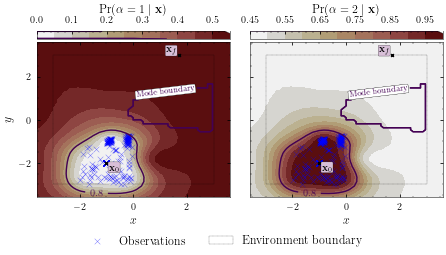

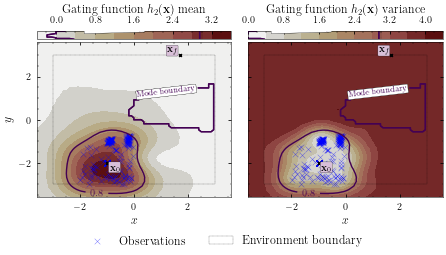

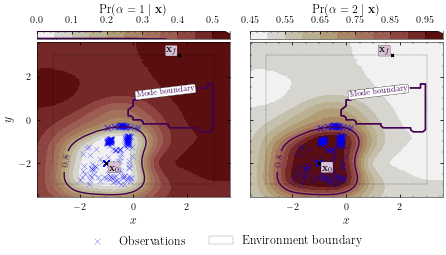

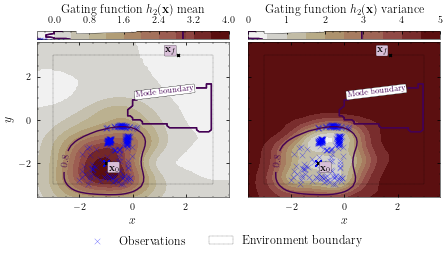

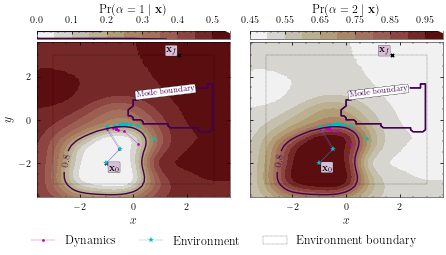

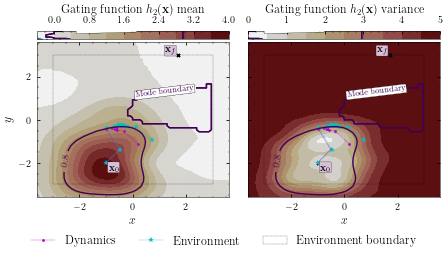

Epoch 1/10000
1/1 [==============================] - 1s 849ms/step - loss: -622.6858 - val_loss: -614.7765
INFO:tensorflow:Assets written to: ./experiments/exploration-prob-0.8/2022-03-30-14-22/2022-04-11-15-49/ckpts/step_3_epoch_0/assets


/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.Categorical_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/Users/aidanscannell/Library/Caches/pypoetry/virtualenvs/modeopt-KAfqa0eY-py3.8/lib/python3.8/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:558: UserWarning: Encoding a StructuredValue with type tfp.distributions.MultivariateNormalDiag_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


Epoch 2/10000
1/1 [==============================] - ETA: 0s - loss: -566.2335

2022-04-11 16:01:05.424831: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-11 16:01:05.424921: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 3s 3s/step - loss: -566.2335 - val_loss: -497.3523
Epoch 3/10000
1/1 [==============================] - ETA: 0s - loss: -548.7256

2022-04-11 16:01:08.482027: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-11 16:01:08.502240: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-11 16:01:08.528946: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_16_01_08

2022-04-11 16:01:08.541214: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_16_01_08/dr-robots-mbp.local.trace.json.gz
2022-04-11 16:01:08.588320: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./experiments/mvn-diag/explorative-prob-0.8/2022-04-11-15-49/train/plugins/profile/2022_04_11_16_01_08

2022-04-11 16:01:08.588720: I tensorflow/core/profiler/rpc/client/save_profile.

1/1 [==============================] - 0s 56ms/step - loss: -548.7256 - val_loss: -477.9262
Epoch 4/10000
1/1 [==============================] - 0s 61ms/step - loss: -672.0315 - val_loss: -618.8510
Epoch 5/10000
1/1 [==============================] - 0s 76ms/step - loss: -591.1209 - val_loss: -612.5820
Epoch 6/10000
1/1 [==============================] - 0s 62ms/step - loss: -656.1546 - val_loss: -589.7194
Epoch 7/10000
1/1 [==============================] - 0s 63ms/step - loss: -624.1417 - val_loss: -382.6576
Epoch 8/10000
1/1 [==============================] - 0s 74ms/step - loss: -673.6487 - val_loss: -532.6004
Epoch 9/10000
1/1 [==============================] - 0s 59ms/step - loss: -624.5757 - val_loss: -426.7420
Epoch 10/10000
1/1 [==============================] - 0s 64ms/step - loss: -664.4504 - val_loss: -584.9862
Epoch 11/10000
1/1 [==============================] - 0s 79ms/step - loss: -537.8188 - val_loss: -541.8339
Epoch 12/10000
1/1 [==============================] - 0s 7

Epoch 80/10000
1/1 [==============================] - 0s 92ms/step - loss: -716.8469 - val_loss: -380.2318
Epoch 81/10000
1/1 [==============================] - 0s 95ms/step - loss: -738.8218 - val_loss: -582.5434
Epoch 82/10000
1/1 [==============================] - 0s 73ms/step - loss: -689.4595 - val_loss: -375.9012
Epoch 83/10000
1/1 [==============================] - 0s 54ms/step - loss: -705.7733 - val_loss: -448.7421
Epoch 84/10000
1/1 [==============================] - 0s 79ms/step - loss: -703.3291 - val_loss: -568.8145
Epoch 85/10000
1/1 [==============================] - 0s 117ms/step - loss: -750.1284 - val_loss: -538.9209
Epoch 86/10000
1/1 [==============================] - 0s 92ms/step - loss: -508.3939 - val_loss: -271.8693
Epoch 87/10000
1/1 [==============================] - 0s 64ms/step - loss: -676.5149 - val_loss: 86.2994
Epoch 88/10000
1/1 [==============================] - 0s 70ms/step - loss: -592.7377 - val_loss: 50.6212
Epoch 89/10000
1/1 [====================

Epoch 156/10000
1/1 [==============================] - 0s 81ms/step - loss: -631.6903 - val_loss: -72.7773
Epoch 157/10000
1/1 [==============================] - 0s 90ms/step - loss: -600.5120 - val_loss: -246.7316
Epoch 158/10000
1/1 [==============================] - 0s 66ms/step - loss: -702.4090 - val_loss: -674.8075
Epoch 159/10000
1/1 [==============================] - 0s 52ms/step - loss: -689.1654 - val_loss: -637.9813
Epoch 160/10000
1/1 [==============================] - 0s 75ms/step - loss: -638.6604 - val_loss: -624.4626
Epoch 161/10000
1/1 [==============================] - 0s 81ms/step - loss: -619.4642 - val_loss: -627.0414
Epoch 162/10000
1/1 [==============================] - 0s 60ms/step - loss: -590.4996 - val_loss: -597.9236
Epoch 163/10000
1/1 [==============================] - 0s 62ms/step - loss: -648.9838 - val_loss: -478.3771
Epoch 164/10000
1/1 [==============================] - 0s 79ms/step - loss: -507.6775 - val_loss: -349.0934
Epoch 165/10000
1/1 [========

Epoch 232/10000
1/1 [==============================] - 0s 48ms/step - loss: -720.7973 - val_loss: -356.4543
Epoch 233/10000
1/1 [==============================] - 0s 68ms/step - loss: -734.8697 - val_loss: -711.1098
Epoch 234/10000
1/1 [==============================] - 0s 71ms/step - loss: -717.2963 - val_loss: -154.4987
Epoch 235/10000
1/1 [==============================] - 0s 47ms/step - loss: -680.2763 - val_loss: -614.4834
Epoch 236/10000
1/1 [==============================] - 0s 70ms/step - loss: -674.1164 - val_loss: -337.6650
Epoch 237/10000
1/1 [==============================] - 0s 70ms/step - loss: -649.3441 - val_loss: -153.5659
Epoch 238/10000
1/1 [==============================] - 0s 50ms/step - loss: -717.7607 - val_loss: -655.7840
Epoch 239/10000
1/1 [==============================] - 0s 79ms/step - loss: -668.2555 - val_loss: -581.9330
Epoch 240/10000
1/1 [==============================] - 0s 80ms/step - loss: -712.7204 - val_loss: -381.9833
Epoch 241/10000
1/1 [=======


KeyboardInterrupt



Error in callback <function flush_figures at 0x191761310> (for post_execute):



KeyboardInterrupt



In [24]:
for step in range(1, num_steps):
    new_dataset = mode_optimiser.explore_env()
    mode_optimiser.update_dataset(new_dataset)
    mode_optimiser.dynamics_fit_kwargs.update({"batch_size": mode_optimiser.dataset[0].shape[0]})
    print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
    plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
    plot_trajectories_over_gating_network_and_save(step=step, save=True)
    plt.show()
    mode_optimiser.optimise_dynamics()

In [ ]:
for step in range(num_steps, num_steps*2):
    new_dataset = mode_optimiser.explore_env()
    mode_optimiser.update_dataset(new_dataset)
    batch_size = mode_optimiser.dataset[0].shape[0]
    mode_optimiser.dynamics_fit_kwargs.update({"batch_size": mode_optimiser.dataset[0].shape[0]})
    print("Data set size: {}".format(mode_optimiser.dataset[0].shape))
    plot_data_over_gating_network_and_save(step=step, epoch=0, save=False)
    plot_trajectories_over_gating_network_and_save(step=step, save=True)
    plt.show()
    mode_optimiser.optimise_dynamics()

In [ ]:
state_diff_cost_matrix